In [ ]:
import os

SUBJECTS_N = 24

recording_names_path        = "baseline/etc/indexes/index_all.txt"  
recording_sumaries_path     = "baseline/etc/summaries/"
recording_sumaries_prologue = "chb"
recording_sumaries_epilogue = "-summary.txt"
selected_indexes_path       = "baseline/etc/indexes_detection/new/"
filename_train              = "train.txt"
filename_valid              = "validation.txt"
filename_test               = "test.txt"

line_recording_name_start   = "File Name: chb"
line_recording_name_end     = ".edf\n"
line_seizures_start         = "Number of Seizures in File: "

with open(recording_names_path) as n: 
    names = n.readlines()
filename_recordings = [n.strip() for n in names]


subjects = {}

for subject_idx in range(1, SUBJECTS_N + 1 ):
    subject_name = f"{subject_idx:02d}"
    subjects[subject_name] = {}
    filename = recording_sumaries_path \
                + recording_sumaries_prologue \
                + subject_name \
                + recording_sumaries_epilogue
    if not os.path.isfile(filename):
        print(f"(!) No summary file for subject {subject_idx:02d}")
    else:
        with open(filename) as f:
            data = f.readlines()
        
        subjects[subject_name]['sz@rec'] = {}
        for l in data:
            if l.startswith(line_recording_name_start):
                record_name     = l[len(line_recording_name_start)+3:-len(line_recording_name_end)]
            if l.startswith(line_seizures_start):
                seizures = int(l[len(line_seizures_start):].strip())
                subjects[subject_name]['sz@rec'][record_name] = seizures

if 0:
    import pprint
    pprint.pprint(subjects)



Make an array with only the amount of seizures detected in each recording

In [ ]:
for s, s_i in zip(subjects, range(SUBJECTS_N)):
    seizures_l = []
    try:
        seizures = subjects[s]["sz@rec"]
        for r in seizures:
            seizures_l.append(seizures[r])
    except KeyError:
        pass
    subjects[s]['seizures'] = seizures_l


Add to the subjects dictionary the index of the first training recording

In [55]:
for subject, sub_i in zip(subjects, range(1,SUBJECTS_N+1)):
    N = len(subjects[subject]['seizures'])
    # At least 5 recordings will be used for testing
    # A maximum of half the recordings will be used for test
    K = -1
    for i in range( 5, int(N/2) ):
        k = N -i
        train_range = subjects[subject]['seizures'][:k]
        test_range  = subjects[subject]['seizures'][k:]
        print(f"{sub_i}: {k} = {test_range}")
        # All train ranges should have at least one seizure recording
        # All test ranges should have at least one seizure recording
        if any(element != 0 for element in train_range) and any(element != 0 for element in test_range): 
            K = k
            break
    subjects[f"{sub_i:02d}"]["test"] = K

1: 37 = [0, 0, 0, 0, 0]
1: 36 = [0, 0, 0, 0, 0, 0]
1: 35 = [0, 0, 0, 0, 0, 0, 0]
1: 34 = [0, 0, 0, 0, 0, 0, 0, 0]
1: 33 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 32 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 31 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 30 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 29 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 28 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 27 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 26 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: 25 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 31 = [0, 0, 0, 0, 0]
2: 30 = [0, 0, 0, 0, 0, 0]
2: 29 = [0, 0, 0, 0, 0, 0, 0]
2: 28 = [0, 0, 0, 0, 0, 0, 0, 0]
2: 27 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 26 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 25 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 24 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 23 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 22 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 21 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: 20 = [0, 0, 0, 0, 0, 0

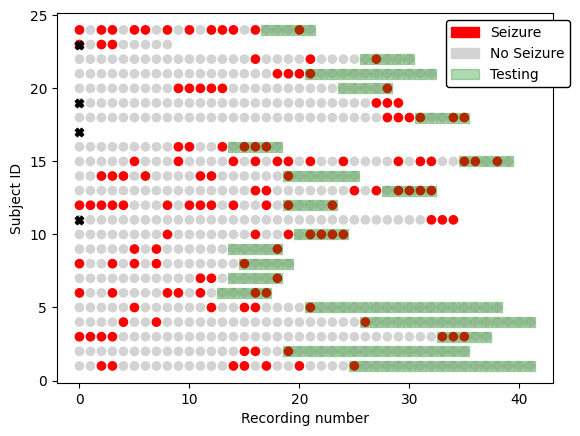

In [63]:
import matplotlib.pyplot as plt
import numpy as np

for subject in subjects:
# for seiz, offset in zip(seizs, offsets):
    offset = int(subject)
    seiz = np.asarray(subjects[subject]['seizures'])
    x = range(len(seiz))
    points = [offset for _ in seiz]
    color =     [ 'red' if s > 0 else 'lightgray' for s in seiz ]
    plt.scatter(x, points, color=color)
    if subjects[subject]["test"] != -1:
        test_x = range(subjects[subject]["test"],len(seiz))
        test_y = [ offset for _ in test_x ]
        plt.scatter(test_x, test_y, color='green', marker="s", s=50, alpha=0.3)
    else:
        plt.scatter([0],[offset], color='k', marker='X')

plt.xlabel("Recording number")
plt.ylabel("Subject ID")

import matplotlib.patches as mpatches
# Create custom legend handles and labels
legend_handles = [mpatches.Circle((0, 0), 1, color='red', label='Seizure'),
                  mpatches.Circle((0, 0), 1, color='lightgray', label='No Seizure'),
                  mpatches.Circle((0, 0), 1, color='green', alpha = 0.3, label='Testing')]
# Add legend with custom handles and labels
plt.legend(handles=legend_handles, bbox_to_anchor=(0.77, 1), fancybox=True, framealpha=1, edgecolor='black')

